In [1]:
from __future__ import print_function
import collections
import numpy as np
import tensorflow as tf
import numpy as np
import zipfile
import pandas as pd
import os
import shutil
import http
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.utils import shuffle
from multiprocessing import Pool, Process
import threading
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
from six.moves.urllib.parse import quote
from sklearn import cross_validation
from random import sample, choice

%matplotlib inline

In [102]:
csv = pd.read_csv('children_de_DE.csv', index_col="imageId")
csv.drop('title', axis=1, inplace=True)
csv.drop('pageURL', axis=1, inplace=True)
csv.drop('imageURL', axis=1, inplace=True)

images = [i[:-4] for i in os.listdir("images_processed/") if i[0] != "."]

csv = csv.loc[images]
csv = csv[csv["breadCrumbs"].notnull()]
def apply(x):
    #return x[-1]
    return x[3] if len(x) > 4 else x[-1]
csv["breadCrumbs"] = csv["breadCrumbs"].str.split("|").apply(apply).astype(int)
print(csv["breadCrumbs"].value_counts()[:20])

161246    3328
161250    2709
161342    1904
177757    1546
161686    1387
161826    1283
161358    1232
161702    1020
161270     977
161314     976
177597     886
177601     821
161478     775
161350     754
161254     749
161902     610
177877     599
172238     593
161338     586
177753     574
Name: breadCrumbs, dtype: int64


In [106]:
csv2cat = csv[csv["breadCrumbs"].isin([177877,161314])]
csvCat = csv[csv["breadCrumbs"].isin([177877,161314,161342])]

In [107]:
#M-WO-KL0008	161314
#M-TS-AST-OPB-SHW	177877
#csv2cat[:5]
#M-SS-SKO-HOO-COF	161342
csvCat[:5]

,sku,breadCrumbs
imageId,,
00083db4d02d0d3046ba2ef6d3ea91c2,M-SS-SKO-HOO-COF,161342
000caa81adca6ef07d2b6a28accf31fa,M-MF-WBR-SCH-KLN,161342
0017b4d4525773a52be56d3ae91e74e7,M-WO-KL0008,161314
00321f74515d763d6da81c66601326ab,M-HK-WBR-HAV-SK3,161342
0040c2f8306361fabd4308ff9a01efb7,M-TS-AST-OPB-SHW,177877


In [108]:
def img(image_file):
    rgb = ndimage.imread(image_file).astype(float)
    rgb = (rgb - 255.0/2) / 255.0
    return rgb

csvCat['image'] = [img(os.path.join("images_processed", h+".jpg")) for h in csvCat.index.tolist()]

/Users/yury/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [110]:
csvCat.shape

(3479, 3)

In [112]:
X1 = np.ndarray(shape=(len(csvCat)*2, 128, 128, 3), dtype=np.float32)
y1 = list()

i = -1
for h, row in csvCat.iterrows():
    i = i+1
    X1[i] = row['image']
    y1.append(row['sku'])
    if i%500 == 0:
        print(i)
    i = i+1
    X1[i] = np.fliplr(row['image'])
    y1.append(row['sku'])



0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [136]:
triplets = list()
sku_dict = dict()
sku_uniq = list()

for i, sku in enumerate(y1):
    if sku not in sku_dict:
        sku_dict[sku] = list()
        sku_uniq.append(sku)
    sku_dict[sku].append(i)

for sku, l in sku_dict.items():
    if len(l) < 2:
        continue
    for i, skui in enumerate(l): 
        t = np.ndarray(shape=(3,), dtype=np.int64)
        t[0] = skui
    
        j = i
        while True:
            j = (j+1)%len(l)
            if j == i:
                continue
            t[1] = l[j]
            break
        for skun, ln in sku_dict.items():
            if skun == sku:
                continue
            t[2] = ln[np.random.randint(len(ln))]
            break
            
    
        triplets.append(t)
triplets = np.array(triplets)
with open("sku_uniq.pickle", 'wb') as f:
    pickle.dump(sku_uniq, f, pickle.HIGHEST_PROTOCOL)
    

In [114]:
triplets

array([[1610, 1611, 2550],
       [1611, 1610, 2550],
       [2550, 2551, 1611],
       ..., 
       [3857, 4378, 1610],
       [4378, 4379, 1610],
       [4379, 3376, 1610]])

In [115]:
sku_uniq[:5]
#M-WO-KL0008	161314 - 2
#M-TS-AST-OPB-SHW	177877 - 4
#M-SS-SKO-HOO-COF	161342 - 0

['M-SS-SKO-HOO-COF',
 'M-MF-WBR-SCH-KLN',
 'M-WO-KL0008',
 'M-HK-WBR-HAV-SK3',
 'M-TS-AST-OPB-SHW']

In [116]:
len(sku_uniq)

967

In [117]:
len(sku_dict)

967

In [118]:
np.random.shuffle(triplets)


In [16]:
def wb(wshape=[None],bshape=[None], device='/cpu:0'):
    with tf.device(device):
        w = tf.get_variable("w", wshape, initializer=tf.truncated_normal_initializer(stddev=0.1))
        b = tf.get_variable('b', bshape, initializer=tf.constant_initializer(0.0))
    print(w.name, w.device, w.get_shape().as_list())
    print(b.name, w.device, b.get_shape().as_list())
    return w, b

In [119]:
# Deep ranking
# http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf
image_size = 128
num_channels = 3
margin = 0.1
batch_size = 16
num_classes = len(sku_dict)
embedding_size = 4096
l2_reg_norm = 5e-5

tf.reset_default_graph() 
graph_con = tf.Graph()
with graph_con.as_default():

    # Input data.
    X_q   = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    X_pos = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    X_neg = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    
    X_eval   = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    

  
    # Variables.
    with tf.variable_scope("convNetConvLayer1"): 
        layer1_weights, layer1_biases = wb([3, 3, 3, 16], [16])
    with tf.variable_scope("convNetConvLayer2"):
        layer2_weights,layer2_biases = wb([3, 3, 16, 64], [64])
    with tf.variable_scope("convNetFCLayer3"):
        layer3_weights, layer3_biases = wb(
            [image_size // 4 * image_size // 4 * 64 , embedding_size], [embedding_size])
#     with tf.variable_scope("embeddings"):
#         embeddings = tf.Variable(tf.random_uniform([num_classes, embedding_size], -1.0, 1.0), trainable=False)
    
    def convNetModel(data, train=False):
        print("data_model", data.get_shape().as_list())
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, layer1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        #pool1 = tf.nn.dropout(pool1, 0.5)
        #pool1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        #print("hidden1", pool1.get_shape().as_list())

        conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, layer2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        #pool2 = tf.nn.lrn(pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm2')
        if train:
             pool2 = tf.nn.dropout(pool2, 0.5)
        #print(pool2.name, pool2.get_shape().as_list())

        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [-1, np.prod(shape[1:])])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases, name='convNetModel_out')
        print(hidden.name, hidden.get_shape().as_list())

#         hidden = tf.matmul(hidden, layer4_weights) + layer4_biases
        return hidden

    # Logits.
    
    out_q = convNetModel(X_q, True)
    out_pos = convNetModel(X_pos, True)
    out_neg = convNetModel(X_neg, True)
    
    scores_pos = tf.reduce_sum(tf.square(out_q - out_pos), 1)
    scores_neg = tf.reduce_sum(tf.square(out_q - out_neg), 1)

#     data_loss = tf.maximum(0., margin + d_pos - d_neg)
#     data_loss = tf.reduce_mean(loss, name="data_loss")
# http://stackoverflow.com/questions/38270166/tensorflow-max-margin-loss-training
# http://stackoverflow.com/questions/37689632/max-margin-loss-in-tensorflow
    loss_matrix = tf.maximum(0., margin + scores_pos - scores_neg)  # we could also use tf.nn.relu here
    print("loss_matrix", loss_matrix.get_shape().as_list())
    loss_data = tf.reduce_sum(loss_matrix)
    
#     embed = tf.nn.embedding_lookup(embeddings, train_dataset)
#     loss = tf.reduce_mean(
#         tf.nn.sampled_softmax_loss(nce_w, nce_b, embed,
#                                train_labels, num_sampled, vocabulary_size))
    
    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + 
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases))
    loss_l2 = l2_reg_norm * regularizers
    # Add the regularization term to the loss.
    loss = loss_data + loss_l2
    
    # Optimizer.
    global_step = tf.Variable(0, trainable=False)
    learn_rate  = tf.train.exponential_decay(0.01, global_step*batch_size, len(triplets), 0.5, staircase=True) # <-- learning rate
    
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss, global_step=global_step)
    #optimizer   = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(loss, global_step=global_step)
    
        
#     optimizer = tf.train.AdamOptimizer(0.001)
#     gradients, v = zip(*optimizer.compute_gradients(loss))
#     g0 = gradients[0]
#     print("Gradients", [g.get_shape().as_list() for g in gradients])
#     gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
#     optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

    #evaluation
    out_eval = convNetModel(X_eval, True)

convNetConvLayer1/w:0 /device:CPU:0 [3, 3, 3, 16]
convNetConvLayer1/b:0 /device:CPU:0 [16]
convNetConvLayer2/w:0 /device:CPU:0 [3, 3, 16, 64]
convNetConvLayer2/b:0 /device:CPU:0 [64]
convNetFCLayer3/w:0 /device:CPU:0 [65536, 4096]
convNetFCLayer3/b:0 /device:CPU:0 [4096]
data_model [16, 128, 128, 3]
convNetModel_out:0 [16, 4096]
data_model [16, 128, 128, 3]
convNetModel_out_1:0 [16, 4096]
data_model [16, 128, 128, 3]
convNetModel_out_2:0 [16, 4096]
loss_matrix [16]
data_model [None, 128, 128, 3]
convNetModel_out_3:0 [None, 4096]


In [121]:
num_steps = (len(triplets)//batch_size)*1
print("Steps", num_steps)

tf.reset_default_graph() 
with tf.Session(graph=graph_con) as session:
    init_op = tf.initialize_all_variables()
    saver = tf.train.Saver()
    init_op.run()
    print("Initialized valiables")
    
    for step in range(num_steps):
        offset = (step * batch_size) % (len(triplets) - batch_size)
        batch_triplets = triplets[offset:(offset + batch_size), :]

        feed_dict = {X_q : X1[batch_triplets[:,0]], X_pos : X1[batch_triplets[:,1]], X_neg :  X1[batch_triplets[:,2]]}
        _, l, ld, l2, sp, sn = session.run([optimizer, loss, loss_data, loss_l2, scores_pos, scores_neg], feed_dict=feed_dict)
        
        if step < 20 or step % 10 == 0:
            print("Step", step)
            print("loss", l, " -> data:", ld, ", l2:",l2)
        if step % 50 == 0:
            print(sp)
            print(sn, "\n")
            
    print("training done, check")
    sku0, sku1 = sku_uniq[0], sku_uniq[1]
    print("> sku0:", sku0, "sku1:", sku1)
    idx = sku_dict[sku0][:2] + sku_dict[sku1][:1]
    emb_list = session.run(out_eval, feed_dict={X_eval:X1[idx]})
    print( emb_list)
    sp, sn = np.sum(np.square(emb_list[0] - emb_list[1])), np.sum(np.square(emb_list[0] - emb_list[2]))
    print("> positive dist:", sp, "negative dist:", sn)
        
    
    print("check done, calculating embeddings")         
    embeddings_np = np.ndarray(shape=tuple(embeddings.get_shape().as_list()), dtype=np.float32)

    for i, sku in enumerate(sku_uniq):
        feed_dict = {X_eval:X1[sku_dict[sku]]}
        embeddings_np[i] = session.run(tf.reduce_mean(out_eval, 0), feed_dict=feed_dict)
        if i == 0:
            print("> mean dist for first sku:", np.sum(np.square(emb_list[0] - embeddings_np[i])))
    norm = np.sqrt(np.sum(np.square(embeddings_np), axis=1))
    norm[norm == 0] = 1
    norm = norm[:,None]
    embeddings_np = embeddings_np/norm
    
    print("calculating embeddings done")
    
    print("check similarity")
    print("sku0", sku_uniq[0], sku_dict[sku_uniq[0]][:2], sku_dict[sku_uniq[0]][0])
    print("sku1", sku_uniq[1], sku_dict[sku_uniq[1]][:2], sku_dict[sku_uniq[1]][0])
    # http://stackoverflow.com/questions/37558899/efficiently-finding-closest-word-in-tensorflow-embedding
    imgid = sku_dict[sku_uniq[0]][0]
    imgid1 = sku_dict[sku_uniq[1]][0]
    print("imgids", imgid, imgid1)
    img = np.concatenate((X1[imgid:imgid+1], X1[imgid1:imgid1+1]), axis=0)
    feed_dict = {X_eval:img}
    check_embeddings = session.run(out_eval, feed_dict=feed_dict)
    print("> check_embeddings.shape", check_embeddings.shape)
    print("> embeddings_np.T", embeddings_np.T.shape)
    similarity = np.dot(check_embeddings, embeddings_np.T)
    for i, sim in enumerate(similarity):
        closest = sim.argsort()[-10:]
        print("> closest i ",i," >>", y1[imgid], closest, [sku_uniq[i] for i in closest])
    
    #embedd_new = embeddings.assign(embeddings_np)
    
    save_path = saver.save(session, "visualsearch_deep_ranking.ckpt")
    pickle_file = "visualsearch_deep_ranking_embeddings.pickle"
    try:
        with open(pickle_file, 'wb') as f:
            pickle.dump(embeddings_np, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        
#     with open(pickle_file, 'rb') as f:
#         save = pickle.load(f)
    print("saved")
        

Steps 434
Initialized valiables
Step 0
loss 5156.6  -> data: 5105.17 , l2: 51.4308
[ 20640.13476562  15383.11230469  16865.375        9923.59472656
  11561.49023438  20541.51171875  14037.29394531  14957.45117188
  11272.01757812   8790.82714844  16476.47265625  10837.00976562
  14867.73242188  14159.84765625  17901.52539062  19828.49023438]
[ 18260.92773438  16532.15234375  16865.65429688  17868.79296875
  17909.76171875  17815.74804688  15975.08496094  16592.8671875
  14528.25195312  17930.79101562  18056.11328125  18398.99023438
  16663.34960938  18078.63671875  18087.51757812  20035.51757812] 

Step 1
loss 29350.7  -> data: 29303.8 , l2: 46.9002
Step 2
loss 1374.3  -> data: 1330.23 , l2: 44.0655
Step 3
loss 45820.8  -> data: 45778.9 , l2: 41.9427
Step 4
loss 179.827  -> data: 139.392 , l2: 40.4345
Step 5
loss 426513.0  -> data: 426473.0 , l2: 39.3128
Step 6
loss 6481.97  -> data: 6443.5 , l2: 38.4645
Step 7
loss 5538.85  -> data: 5500.95 , l2: 37.8941
Step 8
loss 90536.1  -> data: 

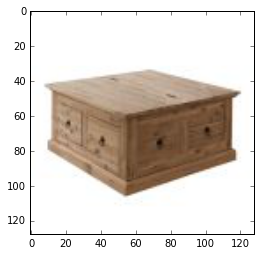

In [131]:
plt.imshow(X1[4]+128.0)

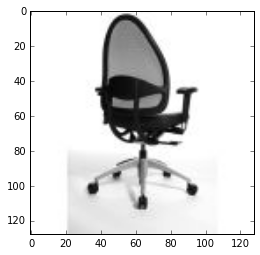

In [135]:
plt.imshow(X1[8]+128.0)

In [96]:
sku_dict["M-AM-WTI-GAM-NBG"][:4]

[394, 395, 622, 623]

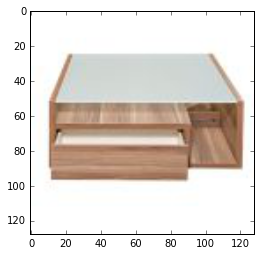

In [97]:
plt.imshow(X1[394]+128.0)

In [123]:
sku_dict["M-CS-000283"][:4]

[2730, 2731, 2956, 2957]

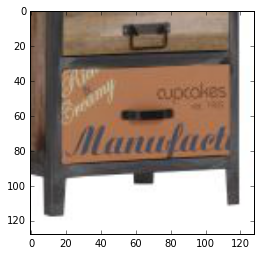

In [125]:
plt.imshow(X1[2730]+128.0)

In [88]:
np.concatenate((X1[imgid:imgid+1], X1[imgid1:imgid1+1]), axis=0).shape

(2, 128, 128, 3)

In [128]:
y1[:10]

['M-SS-SKO-HOO-COF',
 'M-SS-SKO-HOO-COF',
 'M-MF-WBR-SCH-KLN',
 'M-MF-WBR-SCH-KLN',
 'M-WO-KL0008',
 'M-WO-KL0008',
 'M-HK-WBR-HAV-SK3',
 'M-HK-WBR-HAV-SK3',
 'M-TS-AST-OPB-SHW',
 'M-TS-AST-OPB-SHW']